In [129]:
#import libraries
import pennylane as qml
import torch
import torch.autograd
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
import math
import numpy as np
from torchvision import transforms, utils

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Dataloader

class GenericDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None, preprocessing =None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        
        self.data = pd.read_csv(csv_file)

        if preprocessing :
            self.data = preprocessing(self.data)


        
        # shuffle the data
        self.data= self.data.sample(frac=1)
        
        
        
        self.Xs = self.data.iloc[:,0:-1]
        self.labels = self.data.iloc[:,-1]
        self.transform = transform
        self.nfeatures = len(self.Xs.iloc[0,:])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #print(type(idx))
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = torch.tensor(self.Xs.iloc[idx,:].as_matrix()).float()

        
        Y = torch.tensor(self.labels.iloc[idx]).long()

        sample = {'X': X, 'label': Y}

        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def get_nfeatures(self,):
        sample = self[0]
        X = sample['X']
        return(X.shape[0])
        
            

In [3]:
class BC_binary_prep(object):
    def __init__(self,):
        super(BC_binary_prep, self).__init__()
        
    def __call__(self, data): #data is in panda format
        data = data.drop(['Unnamed: 32', 'id'], axis = 1)
        cols = data.columns.tolist()
        cols = cols[1:] + [cols[0]]
        data = data[cols]
        data['diagnosis'].loc[data['diagnosis'] == 'M'] = 0
        data['diagnosis'].loc[data['diagnosis'] == 'B'] = 1
        #data = pd.DataFrame(data.as_matrix(), columns=['SepalLengthCm'  ,'SepalWidthCm','PetalLengthCm','PetalWidthCm', 'Species'])
        return data
        

In [4]:
csv_file = 'breast-cancer-wisconsin-data\data.csv'
data = pd.read_csv(csv_file)
prep = BC_binary_prep()


#composed = transforms.Compose([prep,prepyj])
data = prep(data)
print(data)

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0         17.990         10.38          122.80     1001.0          0.11840   
1         20.570         17.77          132.90     1326.0          0.08474   
2         19.690         21.25          130.00     1203.0          0.10960   
3         11.420         20.38           77.58      386.1          0.14250   
4         20.290         14.34          135.10     1297.0          0.10030   
5         12.450         15.70           82.57      477.1          0.12780   
6         18.250         19.98          119.60     1040.0          0.09463   
7         13.710         20.83           90.20      577.9          0.11890   
8         13.000         21.82           87.50      519.8          0.12730   
9         12.460         24.04           83.97      475.9          0.11860   
10        16.020         23.24          102.70      797.8          0.08206   
11        15.780         17.89          103.60      781.0       

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
class MutualInformationDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""
    def __init__(self, csv_file, encoder):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        
        self.data = pd.read_csv(csv_file)
        # shuffle the data
        self.data= self.data.sample(frac=1)
        
        self.model = encoder
        self.model.evalmode_()
        self.BCprep = BC_binary_prep()
        self.BC_dataset = GenericDataset('breast-cancer-wisconsin-data\data.csv', transform=None, preprocessing = self.BCprep)
        
        dataset = []
        
        with torch.no_grad():
            sample = self.BC_dataset[0]
            X, label = sample['X'], sample['label']
            self.Xs = torch.unsqueeze(X,0)
            self.Ys = torch.unsqueeze(label,0)
            print(0, self.Xs)
            output = self.model(X)
            dataset = [self.model.device._state]
            for j in range(1,len(self.BC_dataset)):
                sample = self.BC_dataset[j]
                X, label = sample['X'], sample['label']
                self.Xs = torch.cat((self.Xs,torch.unsqueeze(X,0)),0)
                self.Ys = torch.cat((self.Ys,torch.unsqueeze(label,0)),0)
                output = self.model(X)
                dataset += [self.model.device._state]

            dataset = np.array(dataset)
            dataset2 = dataset.view(np.float64)
            self.data_encoded = dataset2.reshape(dataset.shape + (2,))

        
        self.data_encoded = torch.tensor(self.data_encoded)
        self.nfeatures = self.Xs.shape[0]

    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        #print(type(idx))

        X = (self.Xs[idx]).float()

        
        Y = (self.data_encoded[idx]).float()

        sample = {'X': X, 'encoded': Y}

        return sample
    
    def get_nfeatures(self,):
        sample = self[0]
        X = sample['X']
        return(len(X[0]))
    
    def get_nencodedfeatures(self,):
        sample = self[0]
        X = sample['encoded']
        return(X[0].shape)





class BC_mutual_inf(object):
    def __init__(self, encoder):
        super(BC_binary_prep, self).__init__()
        self.model = encoder
        self.model.evalmode_()
        self.BCprep = BC_binary_prep
        full_dataset = GenericDataset('breast-cancer-wisconsin-data\data.csv', transform=None, preprocessing = self.BCprep)
        
    def __call__(self, data): #data is in panda format
        yu
        
        
        
        
        
        
        
        
        data = data.drop(['Unnamed: 32', 'id'], axis = 1)
        cols = data.columns.tolist()
        cols = cols[1:] + [cols[0]]
        data = data[cols]
        data['diagnosis'].loc[data['diagnosis'] == 'M'] = 0
        data['diagnosis'].loc[data['diagnosis'] == 'B'] = 1
        #data = pd.DataFrame(data.as_matrix(), columns=['SepalLengthCm'  ,'SepalWidthCm','PetalLengthCm','PetalWidthCm', 'Species'])
        return data
        

In [43]:
csv_file = 'breast-cancer-wisconsin-data\data.csv'
prep = BC_binary_prep()
model = torch.load('modelBC_w3b_1model_id')
mi_dataset = MutualInformationDataset(csv_file, encoder = model)

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 tensor([[1.2360e+01, 2.1800e+01, 7.9780e+01, 4.6610e+02, 8.7720e-02, 9.4450e-02,
         6.0150e-02, 3.7450e-02, 1.9300e-01, 6.4040e-02, 2.9780e-01, 1.5020e+00,
         2.2030e+00, 2.0950e+01, 7.1120e-03, 2.4930e-02, 2.7030e-02, 1.2930e-02,
         1.9580e-02, 4.4630e-03, 1.3830e+01, 3.0500e+01, 9.1460e+01, 5.7470e+02,
         1.3040e-01, 2.4630e-01, 2.4340e-01, 1.2050e-01, 2.9720e-01, 9.2610e-02]])


In [44]:
print(mi_dataset.Xs.size())
print(mi_dataset.data_encoded.size())

torch.Size([569, 30])
torch.Size([569, 8, 2])


In [62]:
train_size = int(0.8 * len(mi_dataset))
test_size = len(mi_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mi_dataset, [train_size, test_size])

In [67]:
decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.Tanh(),
            #nn.Dropout(0.5),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 30))


for name, param in decoder.named_parameters(): #checking the parameters of model
    print(name,param)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr= 1e-2)
num_epochs = 1000

for epoch in range(num_epochs):
    epochlosstrain = 0
    epochlosstest = 0
    decoder.train()
    for j in range(len(train_dataset)):
        sample = train_dataset[j]
        X, encoded = sample['X'],sample['encoded']
        encoded = encoded.reshape(-1)
        # ===================forward=====================
        output = decoder(encoded)
        loss = criterion(output, X)
        epochlosstrain +=loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    decoder.eval()
    with torch.no_grad():
        for j in range(len(test_dataset)):
            sample = mi_dataset[j]
            X, encoded = sample['X'],sample['encoded']
            encoded = encoded.reshape(-1)
            # ===================forward=====================
            output = decoder(encoded)
            loss = criterion(output, X)
            epochlosstest +=loss.item()

    # ===================log========================
    print('epoch [{}/{}], train loss:{:.4f}, valid loss:{:.4f}'
          .format(epoch + 1, num_epochs, epochlosstrain/len(train_dataset), epochlosstest/len(test_dataset)))


0.weight Parameter containing:
tensor([[-0.0500,  0.0912, -0.1187, -0.0309,  0.1777, -0.0115,  0.0180, -0.1582,
         -0.1862,  0.1353, -0.0552,  0.0630, -0.1892,  0.2055,  0.1882, -0.1648],
        [-0.1764, -0.0089,  0.1547, -0.1447,  0.0342,  0.0151,  0.1883,  0.1390,
         -0.1999,  0.0581,  0.1220,  0.1904,  0.1220, -0.1073,  0.1563, -0.1960],
        [-0.1417, -0.0063, -0.1107, -0.0322, -0.0681,  0.1631,  0.1157,  0.0494,
         -0.1919, -0.1285,  0.1970,  0.2469, -0.2225, -0.0700, -0.0204,  0.0676],
        [-0.0484, -0.0025,  0.1645, -0.0326, -0.1280,  0.1416, -0.1558, -0.1153,
          0.2386, -0.1785, -0.1691, -0.0895, -0.1691, -0.1071, -0.1578, -0.0251],
        [-0.0942, -0.2408,  0.1548, -0.0538,  0.1633,  0.0648,  0.0029, -0.1827,
          0.1817, -0.0664,  0.1003,  0.2413,  0.0598, -0.0583,  0.0844,  0.2260],
        [ 0.2233, -0.1832,  0.1117,  0.0017, -0.0458,  0.0886,  0.2257, -0.2344,
          0.2245,  0.0190, -0.0781, -0.0947, -0.0152, -0.2259, -0.0255,  

epoch [10/1000], train loss:8903.8795, valid loss:6394.6403
epoch [11/1000], train loss:8198.8532, valid loss:5728.8659
epoch [12/1000], train loss:7610.5964, valid loss:5158.2079
epoch [13/1000], train loss:7051.4638, valid loss:4864.5659
epoch [14/1000], train loss:7190.5383, valid loss:4687.0259
epoch [15/1000], train loss:6340.6062, valid loss:4186.2705
epoch [16/1000], train loss:6219.5168, valid loss:4129.3933
epoch [17/1000], train loss:5857.5021, valid loss:4173.3826
epoch [18/1000], train loss:5730.9085, valid loss:3769.1588
epoch [19/1000], train loss:5629.1095, valid loss:3828.7214
epoch [20/1000], train loss:5397.7178, valid loss:3815.4924
epoch [21/1000], train loss:5138.3501, valid loss:4201.0272
epoch [22/1000], train loss:5274.1704, valid loss:3755.4413
epoch [23/1000], train loss:4915.8506, valid loss:3634.5304
epoch [24/1000], train loss:4849.6845, valid loss:3969.9399
epoch [25/1000], train loss:4458.4244, valid loss:3672.3458
epoch [26/1000], train loss:4693.7869, v

epoch [146/1000], train loss:4292.5620, valid loss:2840.5906
epoch [147/1000], train loss:4022.4741, valid loss:3491.4069
epoch [148/1000], train loss:3845.1673, valid loss:2859.3882
epoch [149/1000], train loss:3876.1277, valid loss:3091.8933
epoch [150/1000], train loss:4001.4021, valid loss:2578.2901
epoch [151/1000], train loss:4357.7604, valid loss:2948.6475
epoch [152/1000], train loss:3812.3555, valid loss:2795.0925
epoch [153/1000], train loss:4141.5529, valid loss:2953.3738
epoch [154/1000], train loss:4113.5956, valid loss:2827.8985
epoch [155/1000], train loss:3978.3352, valid loss:3210.9884
epoch [156/1000], train loss:3617.4347, valid loss:3052.5333
epoch [157/1000], train loss:4133.8053, valid loss:2932.8008
epoch [158/1000], train loss:3595.5890, valid loss:3062.2887
epoch [159/1000], train loss:3770.7442, valid loss:3015.2682
epoch [160/1000], train loss:3586.9161, valid loss:3346.9662
epoch [161/1000], train loss:3578.6384, valid loss:2802.3531
epoch [162/1000], train 

epoch [281/1000], train loss:3732.5633, valid loss:2992.0113
epoch [282/1000], train loss:3594.6030, valid loss:3023.5697
epoch [283/1000], train loss:3751.9292, valid loss:3612.7614
epoch [284/1000], train loss:3695.9475, valid loss:2903.5553
epoch [285/1000], train loss:3462.7111, valid loss:3453.3934
epoch [286/1000], train loss:3779.0894, valid loss:3152.0489
epoch [287/1000], train loss:3425.7250, valid loss:3353.0390
epoch [288/1000], train loss:3663.9695, valid loss:3386.7121
epoch [289/1000], train loss:3593.4643, valid loss:3369.3056
epoch [290/1000], train loss:3876.6789, valid loss:3002.8013
epoch [291/1000], train loss:3716.6565, valid loss:3042.5896
epoch [292/1000], train loss:3310.8693, valid loss:3038.8810
epoch [293/1000], train loss:3685.3666, valid loss:3331.2993
epoch [294/1000], train loss:3417.8898, valid loss:3169.1395
epoch [295/1000], train loss:3665.8093, valid loss:2866.2385
epoch [296/1000], train loss:3409.5688, valid loss:3034.9033
epoch [297/1000], train 

epoch [416/1000], train loss:3596.1552, valid loss:3130.7697
epoch [417/1000], train loss:3527.0364, valid loss:2961.2962
epoch [418/1000], train loss:3735.0082, valid loss:3056.5693
epoch [419/1000], train loss:3362.3382, valid loss:3005.2891
epoch [420/1000], train loss:3282.9923, valid loss:3072.3264
epoch [421/1000], train loss:3311.2715, valid loss:3024.2172
epoch [422/1000], train loss:3353.8452, valid loss:3017.0532
epoch [423/1000], train loss:3070.1951, valid loss:2933.1364
epoch [424/1000], train loss:3550.7026, valid loss:2631.1056
epoch [425/1000], train loss:3601.8046, valid loss:3187.5256
epoch [426/1000], train loss:3765.6329, valid loss:3159.1256
epoch [427/1000], train loss:3539.0227, valid loss:2890.8931
epoch [428/1000], train loss:3222.1199, valid loss:3035.8464
epoch [429/1000], train loss:3368.7550, valid loss:2978.7659
epoch [430/1000], train loss:3288.8934, valid loss:3179.4082
epoch [431/1000], train loss:3245.8406, valid loss:3085.0507
epoch [432/1000], train 

epoch [551/1000], train loss:3254.5062, valid loss:2892.6438
epoch [552/1000], train loss:3263.7342, valid loss:3125.9411
epoch [553/1000], train loss:3047.2492, valid loss:3000.9733
epoch [554/1000], train loss:3232.6189, valid loss:2997.4566
epoch [555/1000], train loss:3500.6068, valid loss:3159.4542
epoch [556/1000], train loss:3355.9467, valid loss:2992.0733
epoch [557/1000], train loss:3412.3831, valid loss:2986.4539
epoch [558/1000], train loss:3459.4864, valid loss:2995.2339
epoch [559/1000], train loss:3152.6406, valid loss:2937.6247
epoch [560/1000], train loss:3438.6267, valid loss:3106.0891
epoch [561/1000], train loss:2946.0030, valid loss:2919.8263
epoch [562/1000], train loss:3200.6044, valid loss:2937.8232
epoch [563/1000], train loss:3223.6991, valid loss:3493.5087
epoch [564/1000], train loss:3408.8674, valid loss:2767.4077
epoch [565/1000], train loss:2843.0217, valid loss:2776.0252
epoch [566/1000], train loss:3254.0141, valid loss:2646.5759
epoch [567/1000], train 

KeyboardInterrupt: 

In [18]:

b = torch.unsqueeze(torch.ones(4),0)
c = torch.unsqueeze(torch.ones(4)*2,0)
d = torch.cat((b,c),0)
d

tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.]])

In [10]:
import numpy as np
a = torch.zeros((6,4))
len(a[0])

4

In [2]:
model = torch.load('modelBC_w3b_1model_id')

In [3]:
dev = qml.device('default.qubit', wires=4)

In [10]:
#Dataset
csv_file = 'breast-cancer-wisconsin-data\data.csv'
prep = BC_binary_prep()

full_dataset = GenericDataset(csv_file, transform=None, preprocessing = prep)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

full_dataset.get_nfeatures()

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


30

In [15]:
score = torch.zeros(1)
valid_loss_store = torch.zeros(1)
                


with torch.no_grad():

    for j in range(len(test_dataset)):
        #print('evalmode', j)
        sample = test_dataset[j]
        X, label = sample['X'], sample['label']
        output = model(X)
        output = torch.unsqueeze(output,0)
        label = torch.unsqueeze(label,0)
        #output = torch.log(output)#postprocessing(output)
        #valid_loss_store += loss

        _, predicted = torch.max(output.data, 1)
        print('predandlab', predicted, label)
        score += predicted.eq(label).float()
    score = score/len(test_dataset)
    print('acc', score)

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([0]) tensor([0])
predandlab tensor([0]) tensor([0])
predandlab tensor([1]) tensor([1])
predandlab tensor([1]) tensor([1])
predandlab tensor([0

In [28]:
import numpy as np

model.evalmode_()
dataset = []
with torch.no_grad():
    for j in range(10,13):
        sample = test_dataset[11]
        X, label = sample['X'], sample['label']
        output = model(X)
        dataset += [model.device._state]
        
dataset = np.array(dataset)
print('1',dataset)
dataset2 = dataset.view(np.float64)
print('2',dataset2)
dataset3 = dataset2.reshape(dataset.shape + (2,))
print('3',dataset3)


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


1 [[ 0.22766684-0.10493104j -0.1133743 +0.44643881j  0.41466601-0.05405745j
   0.05592543+0.00461174j -0.08803281-0.23648231j  0.45173194-0.37517381j
   0.26586285+0.12893508j  0.002538  +0.22621312j]
 [ 0.22766684-0.10493104j -0.1133743 +0.44643881j  0.41466601-0.05405745j
   0.05592543+0.00461174j -0.08803281-0.23648231j  0.45173194-0.37517381j
   0.26586285+0.12893508j  0.002538  +0.22621312j]
 [ 0.22766684-0.10493104j -0.1133743 +0.44643881j  0.41466601-0.05405745j
   0.05592543+0.00461174j -0.08803281-0.23648231j  0.45173194-0.37517381j
   0.26586285+0.12893508j  0.002538  +0.22621312j]]
2 [[ 0.22766684 -0.10493104 -0.1133743   0.44643881  0.41466601 -0.05405745
   0.05592543  0.00461174 -0.08803281 -0.23648231  0.45173194 -0.37517381
   0.26586285  0.12893508  0.002538    0.22621312]
 [ 0.22766684 -0.10493104 -0.1133743   0.44643881  0.41466601 -0.05405745
   0.05592543  0.00461174 -0.08803281 -0.23648231  0.45173194 -0.37517381
   0.26586285  0.12893508  0.002538    0.22621312]


# separability evolution

In [62]:
class PCA_prep(object): #apply a pca 
    
    def __init__(self, n_components):
        
        self.n_components = n_components
        self.pca = PCA(self.n_components)

    def __call__(self, data):
        x = data[:,0:-1]
        labels = np.expand_dims(data[:,-1],1)
        
        x = self.pca.fit_transform(x)
        print(x.shape, labels.shape)
        data = np.concatenate((x,labels), axis=1)
        return data

In [164]:
csv_file = 'breast-cancer-wisconsin-data\data.csv'
prep = BC_binary_prep()
model = torch.load('modelBC_w9b_2model_id')
mi_dataset = MutualInformationDataset(csv_file, encoder = model)
ordataset = mi_dataset.BC_dataset.data
endataset = mi_dataset.data_encoded

C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 tensor([[2.1560e+01, 2.2390e+01, 1.4200e+02, 1.4790e+03, 1.1100e-01, 1.1590e-01,
         2.4390e-01, 1.3890e-01, 1.7260e-01, 5.6230e-02, 1.1760e+00, 1.2560e+00,
         7.6730e+00, 1.5870e+02, 1.0300e-02, 2.8910e-02, 5.1980e-02, 2.4540e-02,
         1.1140e-02, 4.2390e-03, 2.5450e+01, 2.6400e+01, 1.6610e+02, 2.0270e+03,
         1.4100e-01, 2.1130e-01, 4.1070e-01, 2.2160e-01, 2.0600e-01, 7.1150e-02]])


(212, 2) (357, 2)


C:\Users\barthelemy\.conda\envs\penny\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


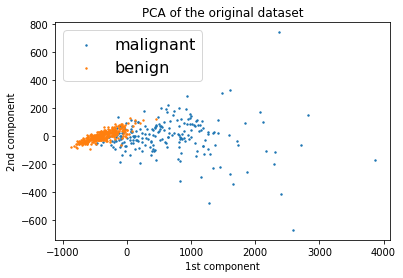

In [156]:
from IPython.display import display

csv_file = 'breast-cancer-wisconsin-data\data.csv'
datar = pd.read_csv(csv_file)

datar= datar.sample(frac=1)
datar= datar.sample(frac=1)
prep = BC_binary_prep()
prepca = PCA_prep(2)

datar = prep(datar)
datar = np.array(datar)
#datar = datar.iloc[:,-3:]
# print('before')
# print(datar.shape,datar[:5,:])
# print(datar[0,0])


X = datar[:,0:-1]
y = datar[:,-1]




fig, ax = plt.subplots(nrows=1, ncols=1)

#plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

l0 = X[y==0]
l1 = X[y==1]


print(l0.shape, l1.shape)
ax.scatter(l0[:,0],l0[:,1],s=2, label = 'malignant')
ax.scatter(l1[:,0],l1[:,1],s=2, label = 'benign')
ax.set_title('PCA of the original dataset')
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.legend(fontsize=16)



labels (569,)
out [[ 0.76937179 -0.08993734]
 [-0.34943342  0.28484811]
 [-0.26919539  0.27864241]
 ...
 [ 0.22457601 -0.25474219]
 [-0.36880245  0.10248742]
 [-0.30068432  0.32685932]]
[ True False False False  True False False False False False False False
 False False False False False False False  True False False False False
  True  True False  True  True False  True False False  True  True False
 False False False False False False  True  True False False False False
 False False False  True  True  True  True  True  True False  True False
  True  True False False False False  True  True False False  True False
 False  True False  True False  True False False False False False  True
 False  True False False  True False False False False  True False  True
 False False False  True  True  True False  True False  True  True False
 False  True False  True  True False False  True False  True  True  True
 False  True False False False  True  True  True False False  True False
  True Fals

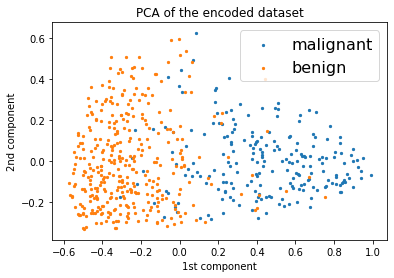

In [166]:
X = np.array(endataset)
#print(X)
X = X.reshape((X.shape[0],1024))
#print(X)
y = np.array(mi_dataset.Ys)
print('labels',y.shape)






fig, ax = plt.subplots(nrows=1, ncols=1)

#plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
print('out',X)
bina = y==0
print(bina)
l0 = X[bina]
print('lo', l0)
l1 = X[y==1]

ax.scatter(l0[:,0],l0[:,1], s=5, label = 'malignant')
ax.scatter(l1[:,0],l1[:,1], s=5, label = 'benign' )

ax.set_title('PCA of the encoded dataset')
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.legend(fontsize=16)





In [20]:
b = []
c = [1]*10
for i in range (100):
    b+=[[i]*10]
    
b = np.zeros((100,10))
for i in range(100):
    for j in range(10):
        b[i,j]= 10*i +j
        

In [52]:
b = pd.DataFrame(b)
b= b.sample(frac=1)
b

,0,1,2,3,4,5,6,7,8,9
37,370.0,371.0,372.0,373.0,374.0,375.0,376.0,377.0,378.0,379.0
19,190.0,191.0,192.0,193.0,194.0,195.0,196.0,197.0,198.0,199.0
8,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0
30,300.0,301.0,302.0,303.0,304.0,305.0,306.0,307.0,308.0,309.0
12,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0
51,510.0,511.0,512.0,513.0,514.0,515.0,516.0,517.0,518.0,519.0
79,790.0,791.0,792.0,793.0,794.0,795.0,796.0,797.0,798.0,799.0
50,500.0,501.0,502.0,503.0,504.0,505.0,506.0,507.0,508.0,509.0
36,360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0
4,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0


In [53]:
np.array(b)

array([[370., 371., 372., 373., 374., 375., 376., 377., 378., 379.],
       [190., 191., 192., 193., 194., 195., 196., 197., 198., 199.],
       [ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.],
       [300., 301., 302., 303., 304., 305., 306., 307., 308., 309.],
       [120., 121., 122., 123., 124., 125., 126., 127., 128., 129.],
       [510., 511., 512., 513., 514., 515., 516., 517., 518., 519.],
       [790., 791., 792., 793., 794., 795., 796., 797., 798., 799.],
       [500., 501., 502., 503., 504., 505., 506., 507., 508., 509.],
       [360., 361., 362., 363., 364., 365., 366., 367., 368., 369.],
       [ 40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.],
       [830., 831., 832., 833., 834., 835., 836., 837., 838., 839.],
       [260., 261., 262., 263., 264., 265., 266., 267., 268., 269.],
       [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
       [590., 591., 592., 593., 594., 595., 596., 597., 598., 599.],
       [ 20.,  21.,  22.,  23.,  2

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


<IPython.core.display.Javascript object>


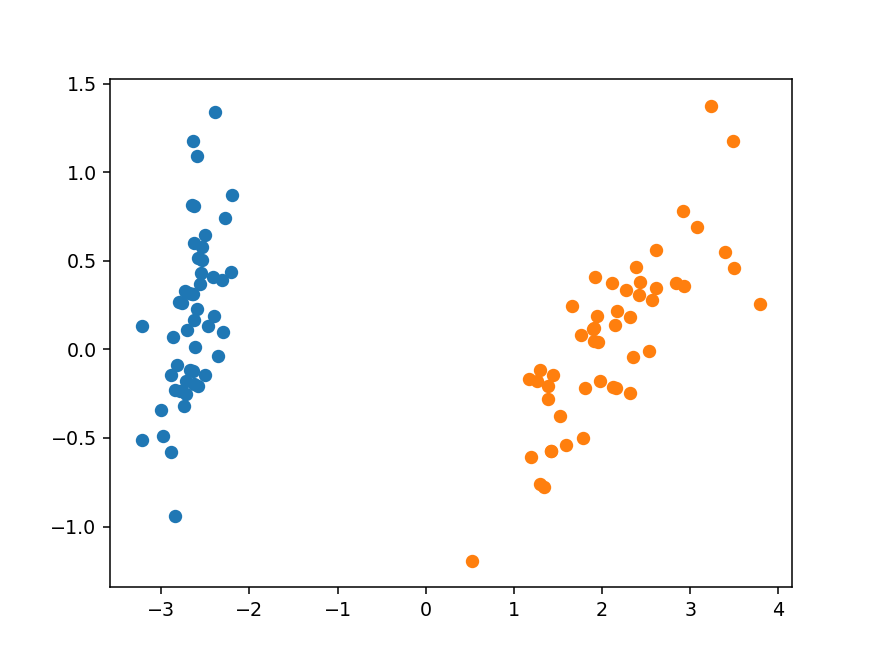

In [86]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X = iris.data

y = iris.target
print(y)
fig, ax = plt.subplots(nrows=1, ncols=1)

#plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

l0 = X[y==0]
l1 = X[y==2]

ax.scatter(l0[:,0],l0[:,1])
ax.scatter(l1[:,0],l1[:,1])



# for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
#     ax.plot(X[y == label, 0].mean(),
#               X[y == label, 1].mean() + 1.5,
#               X[y == label, 2].mean(), name,
#               horizontalalignment='center',
#               bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# # Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [1, 2, 0]).astype(np.float)
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
#            edgecolor='k')

# ax.w_xaxis.set_ticklabels([])
# ax.w_yaxis.set_ticklabels([])
# ax.w_zaxis.set_ticklabels([])

plt.show()